In [28]:
file_path = 'logfile_new.log' # Asegúrate de que el nombre del archivo sea exacto

with open(file_path, 'r') as f:
    log_content = f.readlines()

# Ahora 'log_content' es una lista donde cada elemento es una línea del log
print(log_content[0]) # Imprime la primera línea para verificar

DMESG:



In [29]:
received_packets = []
for line in log_content:
    if (("[PKTS~][secondary_server-UP]" in line and '"rxpk"' in line) or ("[INFO~][PKTS][secondary_server-UP]" in line)):
        received_packets.append(line)

print(f"Se encontraron {len(received_packets)} líneas de paquetes recibidos del servidor secundario (sin estadísticas).")

Se encontraron 574 líneas de paquetes recibidos del servidor secundario (sin estadísticas).


In [30]:
import json
import re

info_packets = []     # (fcnt, linea INFO)
linked_packets = []   # {fcnt: ..., json: {...}}

last_fcnt = None

for line in log_content:
    # Línea tipo INFO (no JSON, contiene fcnt)
    if "[INFO~][PKTS][secondary_server-UP]" in line:
        match = re.search(r'fcnt[:=]\s*(\d+)', line)
        if match:
            last_fcnt = int(match.group(1))
            info_packets.append((last_fcnt, line))

    # Línea tipo PKTS con JSON válido (contiene rxpk)
    elif "[PKTS~][secondary_server-UP]" in line and '"rxpk"' in line:
        try:
            data = json.loads(line[line.find("{"):line.rfind("}")+1])
            if last_fcnt is not None:
                linked_packets.append({"fcnt": last_fcnt, "json": data})
        except Exception:
            pass

print(f"Se encontraron {len(info_packets)} mensajes INFO (con fcnt).")
print(f"Se enlazaron {len(linked_packets)} JSON con su fcnt correspondiente.")

Se encontraron 287 mensajes INFO (con fcnt).
Se enlazaron 284 JSON con su fcnt correspondiente.


In [31]:
import pandas as pd

data = []

for packet in linked_packets:
    fcnt = packet['fcnt']
    rxpk = packet['json']['rxpk'][0]  # Asumimos que siempre hay un elemento en 'rxpk'
    time = rxpk['time']
    freq = rxpk['freq']
    size = rxpk['size']

    data.append({
        'fcnt': fcnt,
        'time': time,
        'freq': freq,
        'size': size
    })

# Crear el DataFrame
df = pd.DataFrame(data)

# Agregar la nueva columna 'tipo' basada en el tamaño del mensaje
df['type'] = df['size'].apply(lambda x: 'voltage' if x == 171 else ('current' if x == 121 else 'battery'))


# Mostrar el DataFrame
print(df)

     fcnt                         time   freq  size     type
0     484  2025-08-22T16:23:09.213210Z  914.3   171  voltage
1     485  2025-08-22T16:23:16.048563Z  913.7   121  current
2     486  2025-08-22T16:23:22.965363Z  914.5   171  voltage
3     487  2025-08-22T16:23:29.807907Z  914.7   121  current
4     488  2025-08-22T16:23:36.730867Z  914.3   171  voltage
..    ...                          ...    ...   ...      ...
279   770  2025-08-22T16:55:50.450133Z  914.7   171  voltage
280   771  2025-08-22T16:55:57.113191Z  913.9    22  battery
281   772  2025-08-22T16:56:03.963786Z  914.3   121  current
282   773  2025-08-22T16:56:10.878156Z  913.7   171  voltage
283   774  2025-08-22T16:56:17.714716Z  914.5   121  current

[284 rows x 5 columns]


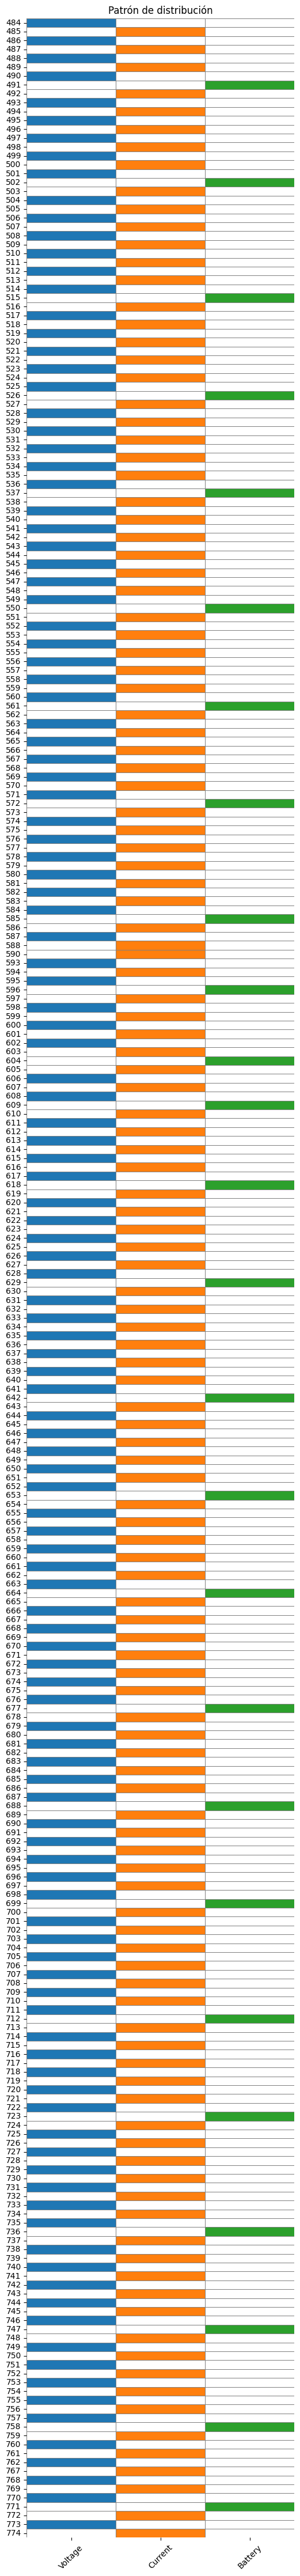

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Mapear a columnas fijas:
# Columna 0 = voltage, 1 = current, 2 = battery
type_mapping = {'voltage': 0, 'current': 1, 'battery': 2}
df['col'] = df['type'].map(type_mapping)

# Construir matriz con NaN donde no toca
n_rows = len(df)
n_cols = 3
matrix = np.full((n_rows, n_cols), np.nan)

for i, (_, row) in enumerate(df.iterrows()):
    matrix[i, row['col']] = row['col']  # valor simbólico para el heatmap

# ---- 🔹 Graficar ----
cmap = sns.color_palette(["#1f77b4", "#ff7f0e", "#2ca02c"])  # azul, naranja, verde

plt.figure(figsize=(6, n_rows/5))
sns.heatmap(matrix, cmap=cmap, cbar=False, linewidths=0.5, linecolor='gray')

plt.yticks(np.arange(n_rows)+0.5, df['fcnt'], rotation=0)
plt.xticks(np.arange(3)+0.5, ["Voltage", "Current", "Battery"], rotation=45)

plt.title("Patrón de distribución")
plt.show()


In [36]:
import json
import pandas as pd

# Cargar JSON desde archivo
with open("ttgolora.json", "r") as f:
    data = json.load(f)

registros = []

for entry in data:
    if "data" in entry and "uplink_message" in entry["data"]:
        uplink = entry["data"]["uplink_message"]
        decoded = uplink.get("decoded_payload", {})

        registros.append({
            "f_cnt": uplink.get("f_cnt"),
            "message_arrival_time": decoded.get("message_arrival_time"),
            "type": decoded.get("type")
        })

# Crear DataFrame
df = pd.DataFrame(registros)

print(df)

     f_cnt  message_arrival_time     type
0      923          1.755883e+12  current
1      922          1.755883e+12  battery
2      921          1.755883e+12  voltage
3      920          1.755883e+12  current
4      919          1.755883e+12  voltage
..     ...                   ...      ...
142    780          1.755882e+12  current
143    779          1.755882e+12  voltage
144    778          1.755882e+12  current
145    777          1.755882e+12  voltage
146    776          1.755882e+12  current

[147 rows x 3 columns]


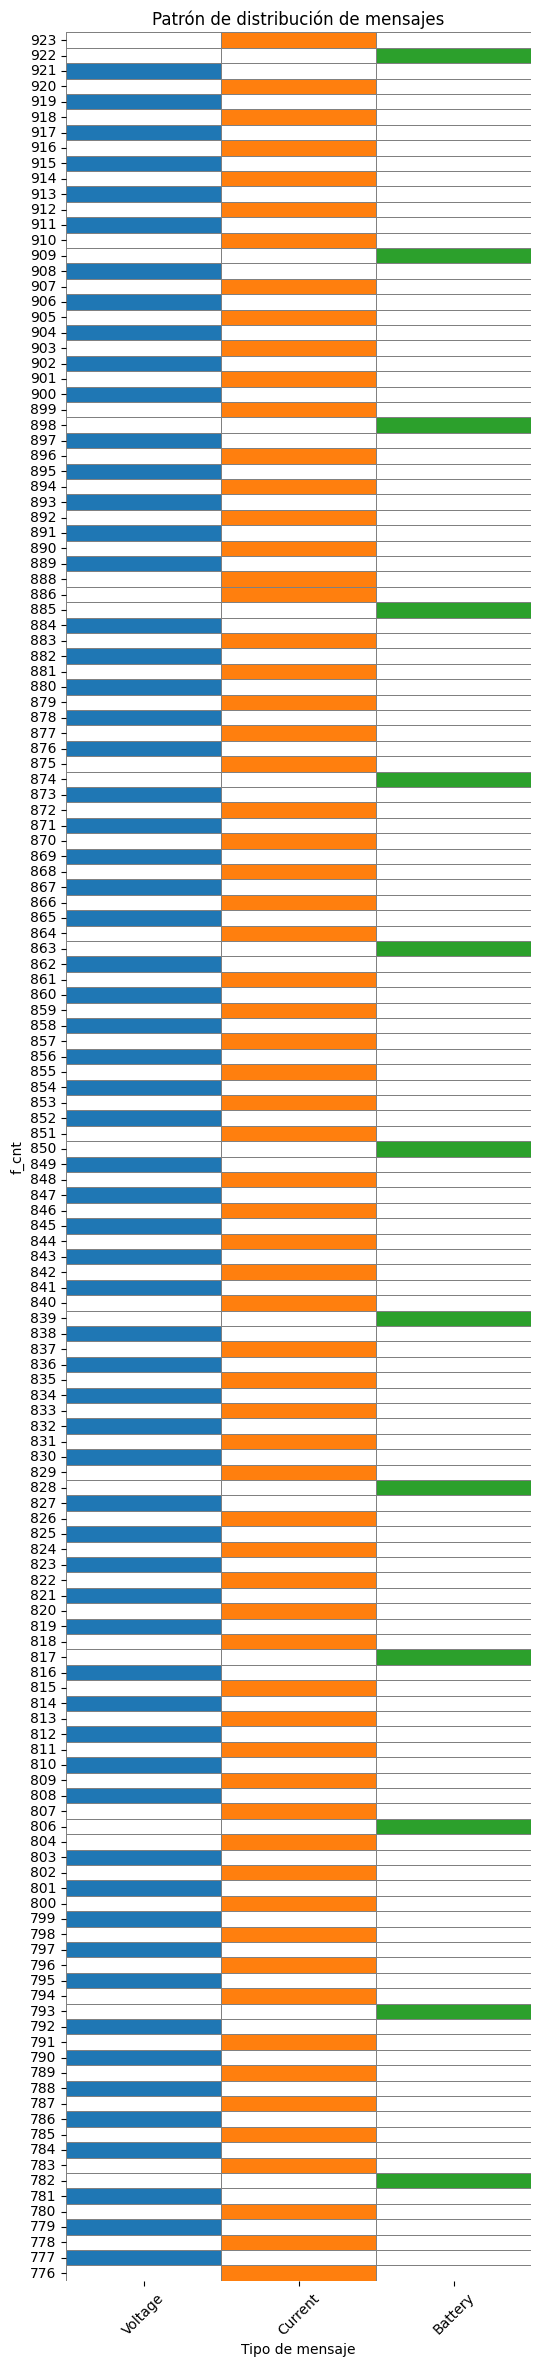

In [40]:

# ==== 2. Mapear los tipos a columnas ====
type_mapping = {'voltage': 0, 'current': 1, 'battery': 2}
df['col'] = df['type'].map(type_mapping)

# ==== 3. Filtrar filas válidas ====
df_valid = df.dropna(subset=['col']).copy()
df_valid['col'] = df_valid['col'].astype(int)

# ==== 4. Construir matriz ====
n_rows = len(df_valid)
n_cols = 3
matrix = np.full((n_rows, n_cols), np.nan)

for i, (_, row) in enumerate(df_valid.iterrows()):
    matrix[i, row['col']] = row['col']  # marcamos posición ocupada

# ==== 5. Graficar patrón ====
cmap = sns.color_palette(["#1f77b4", "#ff7f0e", "#2ca02c"])  # azul, naranja, verde

plt.figure(figsize=(6, n_rows/5))
sns.heatmap(matrix, cmap=cmap, cbar=False, linewidths=0.5, linecolor='gray')

plt.yticks(np.arange(n_rows)+0.5, df_valid['f_cnt'], rotation=0)
plt.xticks(np.arange(3)+0.5, ["Voltage", "Current", "Battery"], rotation=45)

plt.title("Patrón de distribución de mensajes")
plt.xlabel("Tipo de mensaje")
plt.ylabel("f_cnt")
plt.show()